# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances to check to fix them.

In [5]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts
sys.path.insert(0, os.getcwd() + '/../../')  # for util

from scripts.cleaning import noise_detection
data_dir = '../../data'

train instances: 26215
test instances: 6554
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
test set acc: 0.941562
missed test instances (383)
test log loss: 0.18010
test auroc: 0.820

After noise:
model (CatBoostClassifier)
test set acc: 0.883583
missed test instances (763)
test log loss: 0.55343
test auroc: 0.547


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


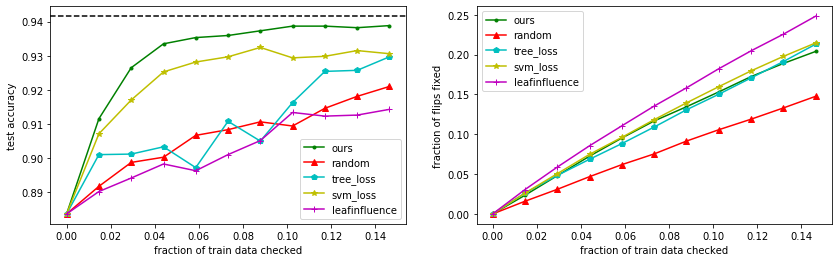

In [2]:
noise_detection(model_type='cb', encoding='tree_output', dataset='amazon', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True)

train instances: 32561
test instances: 16281
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
test set acc: 0.868313
missed test instances (2144)
test log loss: 0.28596
test auroc: 0.923

After noise:
model (CatBoostClassifier)
test set acc: 0.806277
missed test instances (3154)
test log loss: 0.59129
test auroc: 0.826


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


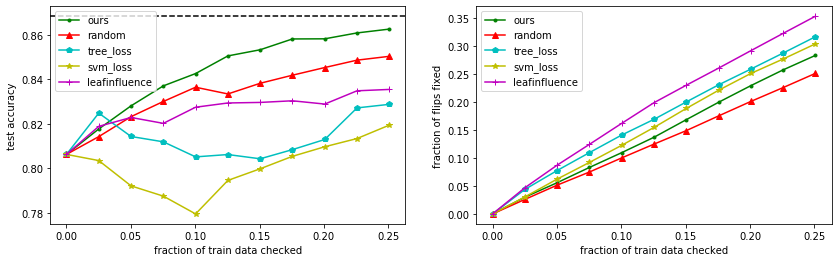

In [4]:
noise_detection(model_type='cb', encoding='tree_output', dataset='adult', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True)

train instances: 3019
test instances: 755
num noisy labels: 800

Before noise:
model (CatBoostClassifier)
test set acc: 0.923179
missed test instances (58)
test log loss: 0.19990
test auroc: 0.969

After noise:
model (CatBoostClassifier)
test set acc: 0.855629
missed test instances (109)
test log loss: 0.42177
test auroc: 0.923


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


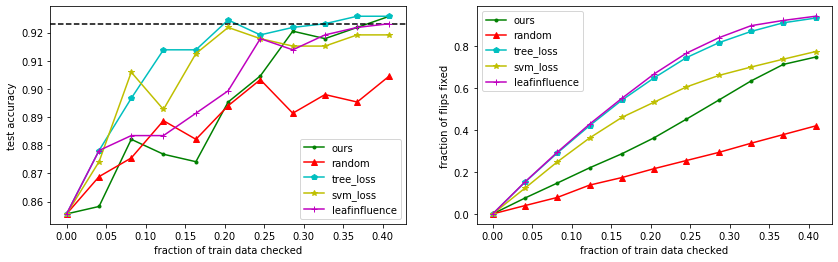

In [3]:
noise_detection(model_type='cb', encoding='tree_output', dataset='medifor2', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True)

train instances: 26215
test instances: 6554
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
test set acc: 0.941562
missed test instances (383)
test log loss: 0.18010
test auroc: 0.820

After noise:
model (CatBoostClassifier)
test set acc: 0.883583
missed test instances (763)
test log loss: 0.55343
test auroc: 0.547


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


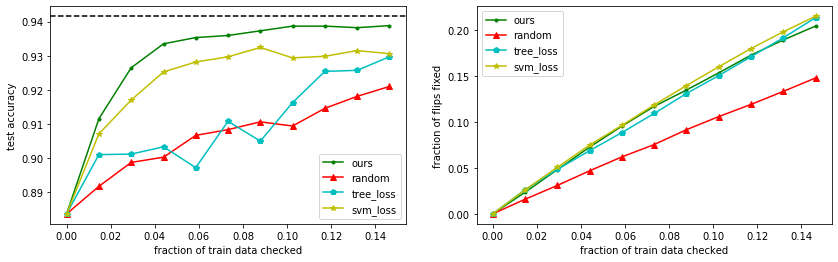

In [6]:
noise_detection(model_type='cb', encoding='tree_output', dataset='amazon', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True)

train instances: 32561
test instances: 16281
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
test set acc: 0.868313
missed test instances (2144)
test log loss: 0.28596
test auroc: 0.923

After noise:
model (CatBoostClassifier)
test set acc: 0.806277
missed test instances (3154)
test log loss: 0.59129
test auroc: 0.826


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


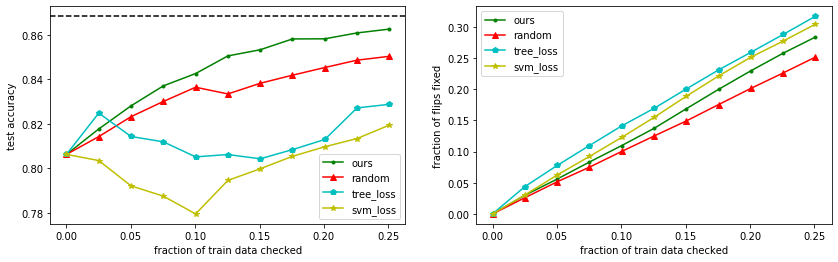

In [7]:
noise_detection(model_type='cb', encoding='tree_output', dataset='adult', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True)